In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## getting data ready

In [ ]:
train_dir = "/content/drive/MyDrive/ml/pizza-steak-sushi/data/train"
test_dir = "/content/drive/MyDrive/ml/pizza-steak-sushi/data/test"

In [ ]:
# since we are using transfer learning, getting the default weight of EfficientNet_B0 weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transform = weights.transforms()


simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming EfficientNet_B0 input size
    transforms.ToTensor(),
])

In [ ]:
# creating device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# getting the data and transforming it to EfficientNet_B0 model's default weight

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=transform,
                                  target_transform=None
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=transform,
                                 target_transform=None)

In [ ]:
class_names = train_data.classes

In [ ]:
# creating batches
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32)

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(32, 3, 224, 224),
         col_names=["input_size","output_size","num_params","trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

## creating model

In [ ]:
 ### freezing the base model and changing the output model to suit our needs

for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
# updating the classifier as per our need
from torch import nn

torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
# writing loss, optimizer and accuracy function to metric our model

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def accuracy_fn(y_pred,y_true):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc



In [ ]:
summary(model, input_size=(32, 3, 224, 224),
         col_names=["input_size","output_size","num_params","trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# training function for training our model
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [ ]:
# testing function to test on unseen data
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



In [ ]:
#training the model

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [ ]:
results = train(model,train_dataloader,test_dataloader,
optimizer,loss_fn,10,device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4353 | train_acc: 0.8164 | test_loss: 0.5215 | test_acc: 0.8456
Epoch: 2 | train_loss: 0.4831 | train_acc: 0.8125 | test_loss: 0.5285 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.4390 | train_acc: 0.8047 | test_loss: 0.4400 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.4283 | train_acc: 0.8281 | test_loss: 0.4171 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.3813 | train_acc: 0.8359 | test_loss: 0.4325 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.4271 | train_acc: 0.8047 | test_loss: 0.4690 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.3859 | train_acc: 0.8438 | test_loss: 0.4735 | test_acc: 0.8153
Epoch: 8 | train_loss: 0.3294 | train_acc: 0.9648 | test_loss: 0.4430 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.2772 | train_acc: 0.9570 | test_loss: 0.3863 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.3173 | train_acc: 0.9492 | test_loss: 0.3873 | test_acc: 0.8769


In [ ]:
import os
if not (os.path.exists("/content/drive/MyDrive/ml/pizza-steak-sushi/model")):
  os.mkdir("/content/drive/MyDrive/ml/pizza-steak-sushi/model")
torch.save(model,"/content/drive/MyDrive/ml/pizza-steak-sushi/model/model3.pt")

In [ ]:
model = torch.load("/content/drive/MyDrive/ml/pizza-steak-sushi/model/model3.pt", map_location=torch.device(device))

In [ ]:
def eval_model(model,test_dataloader,loss_fn,accuracy_fn):
  model.eval()
  with torch.inference_mode():
    y_preds=[]
    loss = 0
    accuracy = 0
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)

      test_logits = model(X)
      y_preds.append(test_logits.argmax(dim=1))

      loss += loss_fn(test_logits, y)
      accuracy += accuracy_fn(test_logits.argmax(dim=1), y)

    y_preds = torch.cat(y_preds)
    return {
        "loss": loss/len(test_dataloader),
        "accuracy": accuracy/len(test_dataloader),
        "preds": y_preds
    }


result = eval_model(model,test_dataloader,loss_fn,accuracy_fn)
print(f"loss: {result['loss']}")
print(f"accuracy: {result['accuracy']:.3f}%")

loss: 0.3873302638530731
accuracy: 87.689%


In [ ]:
y_preds = result["preds"]
y_true = torch.tensor([label for _, label in test_data])

In [ ]:
try:
  import torchmetrics

except:
  !pip install torchmetrics

from torchmetrics.classification import MulticlassConfusionMatrix

matrix = MulticlassConfusionMatrix(num_classes=len(class_names)).to(device)
matx  =matrix(y_preds.to(device), y_true.to(device))


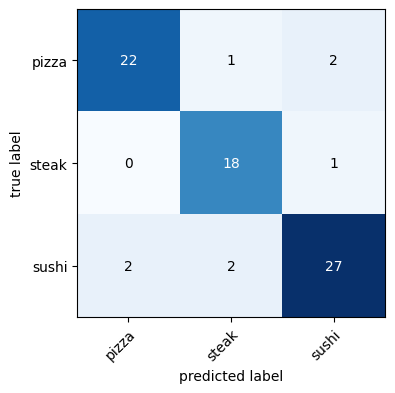

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(conf_mat = matx.to("cpu").numpy(),figsize=(4,4), class_names=class_names);

In [ ]:
from PIL import Image
def pred_and_plot(model,image_path):
  model.eval()
  with torch.inference_mode():
    img = Image.open(image_path)
    image = transform(img).unsqueeze(dim=0).to(device)
    image = simple_transform(img).unsqueeze(dim=0).to(device)

    pred_logits = model(image)
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_label = class_names[pred_probs.argmax(dim=1)]
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Pred: {pred_label}")
    plt.axis("off")


# pred_and_plot(model,"/content/drive/MyDrive/ml/pizza-steak-sushi/data/test/sushi/1230335.jpg")

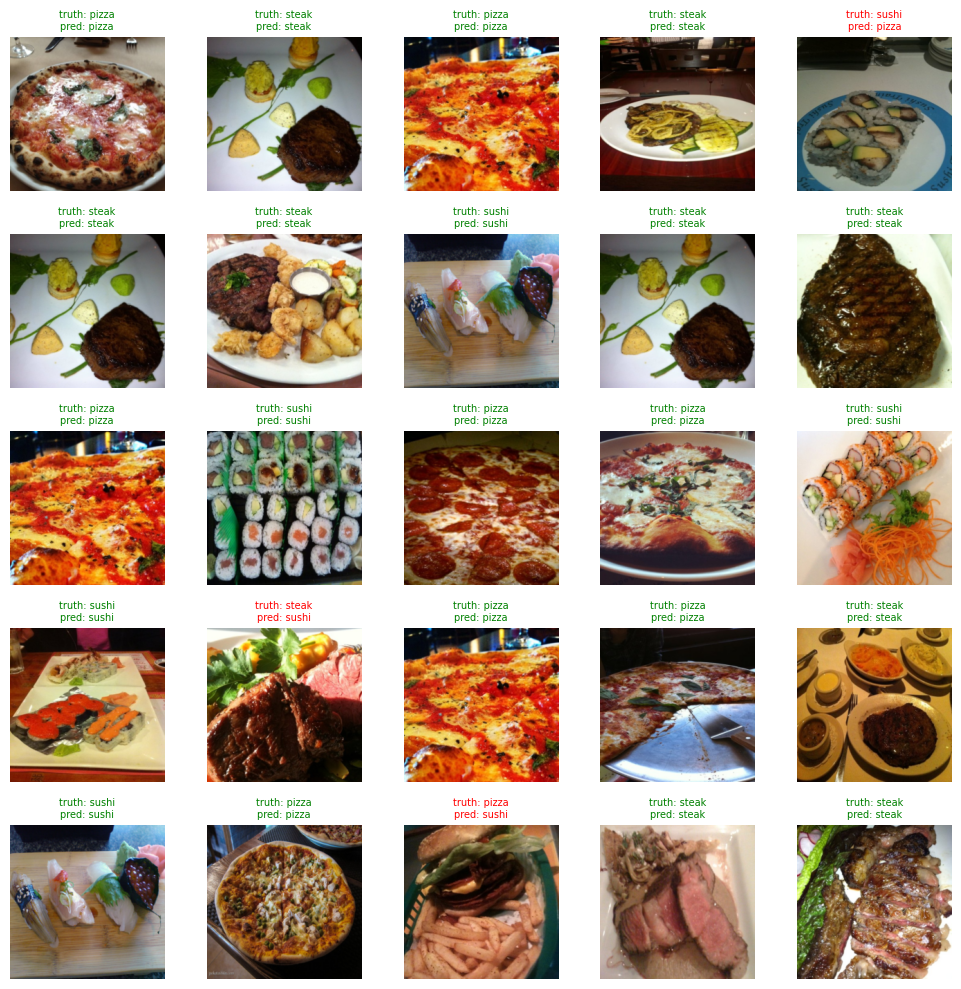

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random



def pred_and_plot(model, data_dir):
    model.eval()
    with torch.inference_mode():
        plt.figure(figsize=(10, 10))

        for i in range(25):
            # Randomly select a class folder and an image
            class_folder = random.choice(os.listdir(data_dir))
            class_path = os.path.join(data_dir, class_folder)
            image_name = random.choice(os.listdir(class_path))
            image_path = os.path.join(class_path, image_name)

            # Load the image
            img = Image.open(image_path)
            label = class_names.index(class_folder)

            # Transform the image
            transformed_image = transform(img)
            simple_transformed_image = simple_transform(img)

            # Perform prediction
            y_logits = model(transformed_image.unsqueeze(dim=0).to(device))
            y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            y_label = class_names[y_pred]
            y_true = class_names[label]

            # Plot the image
            plt.subplot(5, 5, i + 1)
            color = "green" if y_label == y_true else "red"
            plt.imshow(simple_transformed_image.permute(1, 2, 0))
            plt.title(f"truth: {y_true}\npred: {y_label}", color=color, fontsize=7)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Call the function with the model and directory path
data_dir = "/content/drive/MyDrive/ml/pizza-steak-sushi/data/test"
pred_and_plot(model, data_dir)
